Importation de toutes les bibliothéques que j'ai utilisé dans le projet

In [2]:
from datasets import load_dataset
import pandas as pd
from sklearn.utils import class_weight
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score ,classification_report,f1_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


Importation des données 

In [3]:


# Télécharger
dataset = load_dataset("dair-ai/emotion")

# Convertir en DataFrame pandas
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

# Sauvegarder en CSV sur mon PC
df_train.to_csv('emotion_train.csv', index=False)
df_val.to_csv('emotion_validation.csv', index=False)
df_test.to_csv('emotion_test.csv', index=False)

Exploration du dataset 

In [4]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(16000, 2)
(2000, 2)
(2000, 2)


In [5]:
print("Voici une vue global du Dataset:\n")
print(df_train.head(5))
print("\n")
print("Voilà des informatiions sur le Dataset:\n")
df_train.info()

Voici une vue global du Dataset:

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


Voilà des informatiions sur le Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [6]:
emotion_mapping = {
    0: 'sadness',
    1: 'joy', 
    2: 'love',
    3: 'anger',
    4: 'fear', 
    5: 'surprise'
}
df_train['emotion_name'] = df_train['label'].map(emotion_mapping)
df_train.head()

,text,label,emotion_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Nettoyage

In [7]:
df_train.isna().any()



text            False
label           False
emotion_name    False
dtype: bool

In [8]:
df_train[df_train.duplicated(keep=False)]

,text,label,emotion_name
4975,i feel more adventurous willing to take risks ...,1,joy
13846,i feel more adventurous willing to take risks ...,1,joy


In [9]:
df_train.drop_duplicates(inplace=True)

In [10]:
df_train['text'] = df_train['text'].str.lower().str.strip()
df_test['text'] = df_test['text'].str.lower().str.strip()
df_val['text'] = df_val['text'].str.lower().str.strip()

In [11]:
df_train['text'] = df_train['text'].str.replace(r'[^\w\s]', '', regex=True)  # Supprimer ponctuation
df_train['text'] = df_train['text'].str.replace(r'\d+', '', regex=True)  
df_val['text'] = df_val['text'].str.replace(r'[^\w\s]', '', regex=True)  
df_val['text'] = df_val['text'].str.replace(r'\d+', '', regex=True)       # Supprimer les chiffres
df_test['text'] = df_test['text'].str.replace(r'[^\w\s]', '', regex=True)  
df_test['text'] = df_test['text'].str.replace(r'\d+', '', regex=True)       
    

Visualisation

In [12]:
df_train.head()

,text,label,emotion_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [13]:
df_train.groupby("emotion_name")["text"].count()

emotion_name
anger       2159
fear        1937
joy         5361
love        1304
sadness     4666
surprise     572
Name: text, dtype: int64

<Axes: >

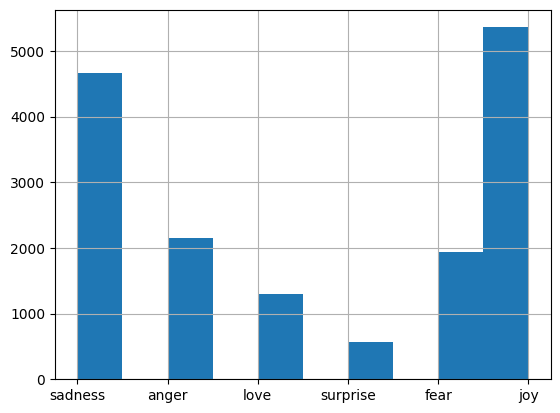

In [14]:
df_train["emotion_name"].hist()

Entrainement sans equilibrage

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(df_train['text'])
X_val_vec = vectorizer.transform(df_val['text'])

# 2. Entraîner sans équilibrage
modele = RandomForestClassifier(n_estimators=100, random_state=42)
modele.fit(X_train_vec, df_train['label'])

# 3. Tester
predictions = modele.predict(X_val_vec)
accuracy = accuracy_score(df_val['label'], predictions)
f1= f1_score(df_test['label'], predictions,average='macro')

# 4. Afficher le résultat
print(f" Accuracy  : {accuracy:.4f}")
print(f" F1_SCORE  : {f1:.4f}")

 Accuracy  : 0.8830
 F1_SCORE  : 0.1668


Paramétres pour tous les méthode d'équilibrege:

In [16]:
#chargement des données 
X_train_vectorized = vectorizer.fit_transform(df_train["text"])
y_train = df_train["label"]
X_val_vectorized = vectorizer.transform(df_val["text"])
y_val=df_val["label"]
#paramétres de Random Forest
n_arbres = 100
graine = 42

 l'Equilibrage avec class_weight 

In [17]:
# 1. Je calcule les poids pour équilibrer les émotions
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

poids_auto = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Je crée un dictionnaire de poids
poids_dict = {emotion: poids for emotion, poids in zip(np.unique(y_train), poids_auto)}

# 2. J'entraîne le modèle avec ces poids
modele = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=poids_dict
)

modele.fit(X_train_vectorized, y_train)

# 3. Je teste
predictions = modele.predict(X_val_vectorized)
accuracy = accuracy_score(y_val, predictions)
f1= f1_score(df_test['label'], predictions,average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f" F1_SCORE  : {f1:.4f}")

Accuracy: 0.8750
 F1_SCORE  : 0.1637


Equilibrage avec la méthode de SMOTE

In [21]:

# création de pipeline avec SMOTE
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=graine)),
    ('classifier', RandomForestClassifier(
        n_estimators=n_arbres,
        random_state=graine
    ))
])

# J'entraîne et je teste
pipeline_smote.fit(X_train_vectorized, y_train)
predictions_smote = pipeline_smote.predict(X_val_vectorized)
accuracy_smote = accuracy_score(y_val, predictions_smote)

print(f"   Accuracy: {accuracy_smote:.4f}")
f1= f1_score(df_val['label'], predictions,average='macro')
print(f" F1_SCORE  : {f1:.4f}")



   Accuracy: 0.8300
 F1_SCORE  : 0.8594


Equilibrage avec Data Augmentation 

In [40]:


# Définition de l'espace des multiplicateurs à tester
param_grid = {
    'mult_2': [1, 2, 3],  # amour
    'mult_3': [1, 2, 3],  # colère
    'mult_4': [1, 2, 3, 4],  # peur
    'mult_5': [1, 2, 3, 4, 5]  # surprise
}

# Initialisation des meilleurs résultats
meilleur_f1 = 0
meilleure_accuracy_correspondante = 0
meilleurs_multiplicateurs = None

# Grid Search
print("Début de la Grid Search - Optimisation F1-score")
for params in ParameterGrid(param_grid):
    # Construction du dictionnaire de multiplicateurs
    multiplicateurs = {
        2: params['mult_2'],
        3: params['mult_3'], 
        4: params['mult_4'],
        5: params['mult_5']
    }
    
    # Duplication des données avec les multiplicateurs courants
    df_augmente = df_train.copy()
    
    for emotion, mult in multiplicateurs.items():
        donnees_emotion = df_train[df_train['label'] == emotion]
        for i in range(mult - 1):
            df_augmente = pd.concat([df_augmente, donnees_emotion])
    
    # Préparation des données
    X_train_augmente = df_augmente['text']
    y_train_augmente = df_augmente['label']
    X_train_augmente_vec = vectorizer.fit_transform(X_train_augmente)
    
    # Entraînement du modèle
    modele_courant = RandomForestClassifier(
        n_estimators=n_arbres,
        random_state=graine
    )
    modele_courant.fit(X_train_augmente_vec, y_train_augmente)
    
    # Évaluation avec F1-score comme métrique principale
    predictions_courant = modele_courant.predict(X_val_vectorized)
    f1_courant = f1_score(y_val, predictions_courant, average='macro')  # ← OPTIMISATION F1
    accuracy_courant = accuracy_score(y_val, predictions_courant)        # ← Pour information
    
    # Mise à jour du meilleur résultat BASÉ SUR F1-SCORE
    if f1_courant > meilleur_f1:
        meilleur_f1 = f1_courant
        meilleure_accuracy_correspondante = accuracy_courant
        meilleurs_multiplicateurs = multiplicateurs.copy()
        print(f"🎯 Nouveau meilleur F1: {f1_courant:.4f} (Accuracy: {accuracy_courant:.4f})")

# Affichage des résultats optimaux SEULEMENT
print(f"\n" + "="*50)
print("=== RÉSULTATS OPTIMAUX ===")
print("="*50)
print(f"Meilleurs multiplicateurs: {meilleurs_multiplicateurs}")
print(f"F1-score optimal (macro): {meilleur_f1:.4f}")
print(f" Accuracy correspondante: {meilleure_accuracy_correspondante:.4f}")
print("="*50)

Début de la Grid Search - Optimisation F1-score
🎯 Nouveau meilleur F1: 0.8552 (Accuracy: 0.8830)


KeyboardInterrupt: 

Equilibrage avec Oversampling

In [22]:


# Je crée un pipeline avec oversampling simple
pipeline_oversample = Pipeline([
    ('oversample', RandomOverSampler(random_state=graine)),
    ('classifier', RandomForestClassifier(
        n_estimators=n_arbres,
        random_state=graine
    ))
])

# J'entraîne et je teste
pipeline_oversample.fit(X_train_vectorized, y_train)
predictions_oversample = pipeline_oversample.predict(X_val_vectorized)
accuracy_oversample = accuracy_score(y_val, predictions_oversample)

print(f"   Accuracy: {accuracy_oversample:.4f}")
f1= f1_score(df_test['label'], predictions,average='macro')
print(f" F1_SCORE  : {f1:.4f}")

   Accuracy: 0.8790
 F1_SCORE  : 0.1637


 la phase d'entrainement 

Random Forest

In [23]:



# Pipeline avec SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Hyperparamètres
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# PHASE 1: RECHERCHE HYPERPARAMÈTRES AVEC VALIDATION CROISÉE SUR TRAIN
print("Recherche hyperparamètres ")
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_vectorized, y_train)

# Résultats validation croisée
print("\nMEILLEURS PARAMÈTRES ")
print("F1-macro moyen (5 folds): {:.4f}".format(random_search.best_score_))
for param, value in random_search.best_params_.items():
    param_name = param.replace('classifier__', '')
    print("   {}: {}".format(param_name, value))

# PHASE 2: VALIDATION SUR df_val

print("PHASE 2: Validation  avec les meilleurs paramètres...")

best_model = random_search.best_estimator_

# Évaluation sur df_val
y_val_pred = best_model.predict(X_val_vectorized)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_macro_val = f1_score(y_val, y_val_pred, average='macro')
f1_per_class_val = f1_score(y_val, y_val_pred, average=None)

print("PERFORMANCE SUR df_val:")
print("F1-macro: {:.4f}".format(f1_macro_val))
print("Accuracy: {:.4f}".format(accuracy_val))

Recherche hyperparamètres 
Fitting 5 folds for each of 30 candidates, totalling 150 fits

MEILLEURS PARAMÈTRES 
F1-macro moyen (5 folds): 0.8270
   n_estimators: 300
   min_samples_split: 5
   min_samples_leaf: 4
   max_features: log2
   max_depth: None
PHASE 2: Validation  avec les meilleurs paramètres...
PERFORMANCE SUR df_val:
F1-macro: 0.8631
Accuracy: 0.8835


Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Pipeline Regression Logistique
pipeline_lr = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, n_jobs=-1))
])

# Hyperparamètres Regression Logistique
param_grid_lr = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs', 'sag'],
    'classifier__max_iter': [1000, 2000],
    'classifier__penalty': ['l2', 'none']
}

# Recherche hyperparamètres
random_search_lr = RandomizedSearchCV(
    estimator=pipeline_lr,
    param_distributions=param_grid_lr,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Recherche hyperparamètres Regression Logistique")
random_search_lr.fit(X_train_vectorized, y_train)

# Résultats
print("\nMEILLEURS PARAMÈTRES REGRESSION LOGISTIQUE:")
print("F1-macro (validation croisée): {:.4f}".format(random_search_lr.best_score_))
for param, value in random_search_lr.best_params_.items():
    param_name = param.replace('classifier__', '')
    print("   {}: {}".format(param_name, value))

# Validation sur df_val
best_model = random_search_lr.best_estimator_ 
y_val_pred = best_model.predict(X_val_vectorized)

# Calcul des deux métriques
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("\nPERFORMANCE SUR df_val:")
print("   F1-macro: {:.4f}".format(f1_val))
print("   Accuracy: {:.4f}".format(accuracy_val))



Recherche hyperparamètres Regression Logistique
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\1\AppData\Local\Program


MEILLEURS PARAMÈTRES REGRESSION LOGISTIQUE:
F1-macro (validation croisée): 0.8557
   solver: liblinear
   penalty: l2
   max_iter: 1000
   C: 10

PERFORMANCE SUR df_val:
   F1-macro: 0.8760
   Accuracy: 0.8980


XGBoost

In [33]:
from xgboost import XGBClassifier


# Pipeline XGBoost
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
])

# Hyperparamètres XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

# Recherche hyperparamètres
random_search_xgb = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=25,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Recherche hyperparamètres XGBoost...")
random_search_xgb.fit(X_train_vectorized, y_train)

# Résultats
print("\nMEILLEURS PARAMÈTRES XGBOOST:")
print("F1-macro (validation croisée): {:.4f}".format(random_search_xgb.best_score_))
for param, value in random_search_xgb.best_params_.items():
    param_name = param.replace('classifier__', '')
    print("   {}: {}".format(param_name, value))

# Validation sur df_val
best_model_xgb = random_search_xgb.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_vectorized)
f1_val_xgb = f1_score(y_val, y_val_pred, average='macro')
accuracy = accuracy_score(y_val, y_val_pred)


print(f" Accuracy: {accuracy:.4f} ")
print("F1-macro sur df_val: {:.4f}".format(f1_val_xgb))


Recherche hyperparamètres XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

SVM

In [29]:
from sklearn.svm import SVC




# Pipeline SVM
pipeline_svm = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(random_state=42))
])

# Hyperparamètres SVM
param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__degree': [2, 3]  # Pour kernel poly
}

# Recherche hyperparamètres
random_search_svm = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=param_grid_svm,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Recherche hyperparamètres SVM...")
random_search_svm.fit(X_train_vectorized, y_train)

# Résultats
print("\nMEILLEURS PARAMÈTRES SVM:")
print("F1-macro (validation croisée): {:.4f}".format(random_search_svm.best_score_))
for param, value in random_search_svm.best_params_.items():
    param_name = param.replace('classifier__', '')
    print("   {}: {}".format(param_name, value))

# Validation sur df_val
best_model_svm = random_search_svm.best_estimator_
y_val_pred_svm = best_model_svm.predict(X_val_vectorized)

# Calcul des deux métriques
accuracy_val_svm = accuracy_score(y_val, y_val_pred_svm)
f1_val_svm = f1_score(y_val, y_val_pred_svm, average='macro')

print("\nPERFORMANCE SVM SUR df_val:")
print("   F1-macro: {:.4f}".format(f1_val_svm))
print("   Accuracy: {:.4f}".format(accuracy_val_svm))



Recherche hyperparamètres SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

MEILLEURS PARAMÈTRES SVM:
F1-macro (validation croisée): 0.8385
   kernel: linear
   gamma: scale
   degree: 2
   C: 1

PERFORMANCE SVM SUR df_val:
   F1-macro: 0.8691
   Accuracy: 0.8905


Phase de test

In [37]:
#tester le XGBoost sur les données de test 


pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        subsample=1.0,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.2,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    ))
])

# Entraînez le pipeline (SMOTE sera appliqué automatiquement)
pipeline.fit(X_train_vectorized, y_train)


# récupération des données de test 
X_test_vectorized = vectorizer.transform(df_test["text"])
y_test=df_test["label"]
# Prédictions sur le test set
y_pred_test = pipeline.predict(X_test_vectorized)

# Calcul des métriques
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_macro_test = f1_score(y_test, y_pred_test, average='macro')

print("RESULTATS SUR LE TEST SET:")
print(f"  - Accuracy: {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")
print(f"  - F1-score (macro): {f1_macro_test:.4f}")



RESULTATS SUR LE TEST SET:
  - Accuracy: 0.8935 (89.35%)
  - F1-score (macro): 0.8529


Analyse par classe

ANALYSE SIMPLIFIEE

METRIQUES PAR EMOTION:
Emotion    Precision  Recall     F1-Score   Support   
--------------------------------------------------
sadness    0.9653     0.9105     0.9371     581.0     
joy        0.9184     0.8906     0.9043     695.0     
love       0.7243     0.8428     0.7791     159.0     
anger      0.9036     0.9200     0.9117     275.0     
fear       0.8690     0.8884     0.8786     224.0     
surprise   0.6310     0.8030     0.7067     66.0      

MATRICE DE CONFUSION (POURCENTAGES):


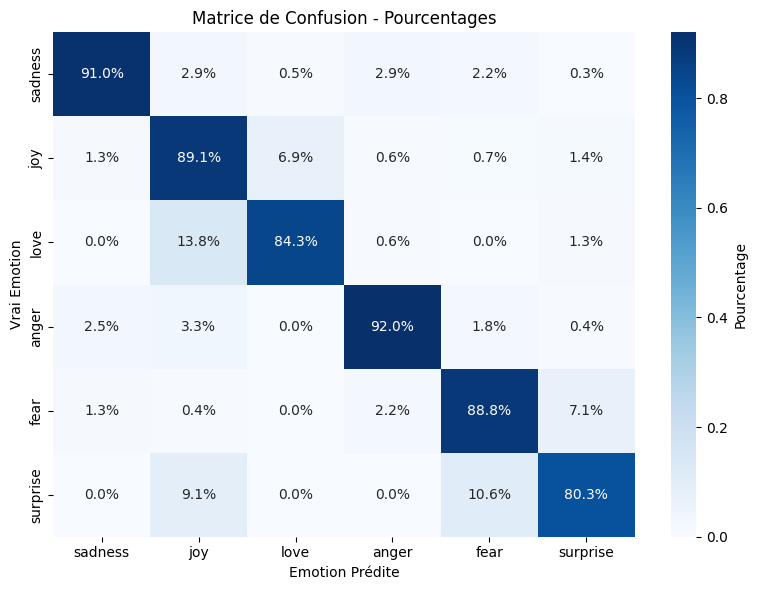


F1-Score le plus élevé: 0.9371
F1-Score le plus bas: 0.7067
Écart: 0.2304


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Analyse simplifiée
print("ANALYSE SIMPLIFIEE")
print("=" * 40)

# 1. Métriques par émotion
class_report = classification_report(y_test, y_pred_test, output_dict=True)
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

print("\nMETRIQUES PAR EMOTION:")
print("=" * 40)
print(f"{'Emotion':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 50)

for i, emotion in enumerate(emotion_labels):
    precision = class_report[str(i)]['precision']
    recall = class_report[str(i)]['recall']
    f1 = class_report[str(i)]['f1-score']
    support = class_report[str(i)]['support']
    
    print(f"{emotion:<10} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")

# 2. Matrice de confusion en pourcentages seulement
print("\nMATRICE DE CONFUSION (POURCENTAGES):")
print("=" * 40)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels,
            cbar_kws={'label': 'Pourcentage'})
plt.title('Matrice de Confusion - Pourcentages')
plt.ylabel('Vrai Emotion')
plt.xlabel('Emotion Prédite')
plt.tight_layout()
plt.show()

# 3. Résumé très court
best_f1 = max([class_report[str(i)]['f1-score'] for i in range(6)])
worst_f1 = min([class_report[str(i)]['f1-score'] for i in range(6)])

print(f"\nF1-Score le plus élevé: {best_f1:.4f}")
print(f"F1-Score le plus bas: {worst_f1:.4f}")
print(f"Écart: {best_f1 - worst_f1:.4f}")

In [50]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Charger et vectoriser les données
X_train = df_train['text']
y_train = df_train['label']

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)

# 2. Appliquer SMOTE manuellement
print("Application de SMOTE...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vectorized, y_train)

# 3. Entraîner XGBoost directement
print("Entraînement de XGBoost...")
xgb_model = XGBClassifier(
    subsample=1.0,
    n_estimators=300,
    max_depth=6, 
    learning_rate=0.2,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_balanced, y_train_balanced)
print("Modèle entraîné!")

# 4. Tester
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
test_phrases = [
    "I am so happy and excited today!",
    "This situation makes me very angry and frustrated", 
    "I feel scared and anxious about the future",
    "I love you so much my dear",
    "What a wonderful surprise this is!",
    "I feel so sad and lonely right now",
    "This news terrifies me completely",
    "I'm overjoyed with this amazing result"
]

print("TESTS MANUELS")


for i, phrase in enumerate(test_phrases, 1):
    phrase_vectorized = vectorizer.transform([phrase])
    prediction_code = xgb_model.predict(phrase_vectorized)[0]
    emotion = emotion_map[prediction_code]
    
    print(f"Test {i}: '{phrase}'")
    print(f"Émotion: {emotion.upper()}")
  

Application de SMOTE...
Entraînement de XGBoost...
Modèle entraîné!
TESTS MANUELS
Test 1: 'I am so happy and excited today!'
Émotion: JOY
Test 2: 'This situation makes me very angry and frustrated'
Émotion: ANGER
Test 3: 'I feel scared and anxious about the future'
Émotion: FEAR
Test 4: 'I love you so much my dear'
Émotion: JOY
Test 5: 'What a wonderful surprise this is!'
Émotion: JOY
Test 6: 'I feel so sad and lonely right now'
Émotion: SADNESS
Test 7: 'This news terrifies me completely'
Émotion: JOY
Test 8: 'I'm overjoyed with this amazing result'
Émotion: SURPRISE


In [53]:
# save_model_with_smote.py
import joblib
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 1. Charger vos données
texts = df_train['text']  
emotions = df_train['emotion_name']  

# 2. Créer le vectorizer et label encoder
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(texts)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(emotions)

# 3. Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 4. Entraîner le modèle XGBoost sur les données équilibrées
xgb_model = xgb.XGBClassifier(
    subsample=1.0,
    n_estimators=300,
    max_depth=6, 
    learning_rate=0.2,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_resampled, y_resampled)

# 5. Sauvegarder TOUT
joblib.dump({
    'model': xgb_model,
    'vectorizer': tfidf_vectorizer, 
    'label_encoder': label_encoder,
    'smote_applied': True  
}, 'mon_modele_xgboost_smote.pkl')

print("Modèle avec SMOTE créé et sauvegardé!")

Modèle avec SMOTE créé et sauvegardé!
